First, we need to import the proper libraries and methods to query Gaia and then manipulate the data to achieve the results that we desire; specifically, we would like to apply cuts to the dataset given by Gaia so that we can create color-absolute magnitude diagrams. Additionally, we would like to cache the results so that we may store them locally. This allows us to have the data on hand without having to perform another query in the instance that Gaia crashes or some other phenomenon leaving us with no way of querying Gaia happens.

In [3]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from joblib import Memory
import random
import read_mist_models
import csv

from astroquery.gaia import Gaia

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from joblib import Memory
location_hyades ='.\cachedir_hyades'
location_m67 = '.\cachedir_m67'
location_ngc6397 = '.\cachedir_ngc6397'
memory_hyades = Memory(location_hyades, verbose=0)
memory_m67 = Memory(location_m67, verbose=0)
memory_ngc6397 = Memory(location_ngc6397, verbose=0)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


We would like a function that can query Gaia for us and store the data locally so that we may access it without having to run another costly computation. We also demand another query function which can apply photometric filters for us so we do not have to apply them manually and let ADQL handle the algorithm for that.

In [4]:
### Function that queries Gaia for data          ###
### within a large circle about a point          ###

### Inputs:                                      ###

### radius == radius of circle                   ###
### ra     == right ascension                    ###
### dec    == declination                        ###
### parLB  == parallax lower bound               ###
### parUB  == parallax upper bound               ###
### pmraLB == right ascension motion lower bound ###
### pmraUB == right ascension motion upper bound ###
### pmdecLB == declination motion lower bound    ###
### pmdecUB == declination motion upper bound    ###

### Outputs:                                     ###
### a numpy array of numpy arrays which we can   ###
### manipulate to graph data                     ###

def gaia_query(radius, ra, dec, parLB, parUB, pmraLB, pmraUB, pmdecLB, pmdecUB):
    
    job = Gaia.launch_job_async(f"SELECT * \
          FROM gaiaedr3.gaia_source \
          WHERE CONTAINS(POINT('ICRS', gaiaedr3.gaia_source.ra, gaiaedr3.gaia_source.dec) \
          ,CIRCLE('ICRS',{ra},{dec},{radius}))=1 \
          AND pmra IS NOT NULL AND abs(pmra)>0 \
          AND pmdec IS NOT NULL AND abs(pmdec)>0 \
          AND pmra BETWEEN {pmraLB} AND {pmraUB} \
          AND pmdec BETWEEN {pmdecLB} AND {pmdecUB} \
          AND parallax BETWEEN {parLB} AND {parUB} \
          ;")
    
    return job.get_results()

### Function that does the above but also applies ###
### photometric cuts to the data                  ###

### Inputs:                              ###
### params == dictionary of parameters   ###

### Outputs:                             ###
### a numpy array of numpy arrays which  ###
### we can manipulate to graph data      ###


def gaia_q_phot_filt(params):
    
    job = Gaia.launch_job_async(f"SELECT * \
          FROM gaiaedr3.gaia_source \
          WHERE CONTAINS(POINT('ICRS', gaiaedr3.gaia_source.ra, gaiaedr3.gaia_source.dec) \
          ,CIRCLE('ICRS',{params['ra']},{params['dec']},{params['radius']}))=1 \
          AND pmra IS NOT NULL AND abs(pmra)>0 \
          AND pmdec IS NOT NULL AND abs(pmdec)>0 \
          AND pmra BETWEEN {params['pmraLB']} AND {params['pmraUB']} \
          AND pmdec BETWEEN {params['pmdecLB']} AND {params['pmdecUB']} \
          AND parallax BETWEEN {params['parLB']} AND {params['parUB']} \
          AND astrometric_excess_noise < {params['aen']} \
          AND phot_g_mean_flux_over_error > {params['phot_g_mean_flux_over_error']} \
          AND phot_bp_mean_flux_over_error > {params['phot_bp_mean_flux_over_error']} \
          AND phot_rp_mean_flux_over_error > {params['phot_rp_mean_flux_over_error']} \
          AND phot_bp_rp_excess_factor BETWEEN 1.0+0.015*(bp_rp)*(bp_rp) AND 1.3+0.06*(bp_rp)*(bp_rp) \
          ;")
    
    return job.get_results()


### Functions for each cluster that cache the results ###
### to be used for later purposes                     ###


gaia_query_hyades = memory_hyades.cache(gaia_query)
gaia_query_m67 = memory_m67.cache(gaia_query)
gaia_query_ngc6397 = memory_ngc6397.cache(gaia_query)

gaia_q_phot_filt_hyades = memory_hyades.cache(gaia_q_phot_filt)
gaia_q_phot_filt_m67 = memory_m67.cache(gaia_q_phot_filt)
gaia_q_phot_filt_ngc6397 = memory_ngc6397.cache(gaia_q_phot_filt)

Later on, we will need a function which reads in the PARSEC .dat files and manipulates the data structure within the file to create a new data structure which is easy to plot and allows us to compare PARSEC and MIST models.

In [32]:
### Function that outputs PARSEC data in graphable form give ###
### cluster name, array of ages, and metallicity array       ###
### for the data                                             ###

### Input                                ###
### cluster_name == name of cluster      ###
### age_arr == array of ages             ###
### metal_arr == array of metalicites    ###

### Output                                                ###
### final_list == list of lists of dictionaries of lists  ###

def parsec_data(cluster_name, age_arr, metal_arr):
    
    
    # magnitude list #
    mag = []
    
    # BP minus RP band photometric data #
    bp_rp = []
    
    # list containing dictionaries of photometric data lists #
    photo_list = []
    
    # final list containing all lists of dicts of data #
    final_data = []
    
    # loops through metallicity array #
    for val in metal_arr:
    
        #reads in data from .dat file#
        data = np.loadtxt(f'{cluster_name}_parsec/{cluster_name}_parsec_{val}.dat')

        # loops through age array to add photometric data for each age at a corresponding [Fe/H] val #
        for i in range(len(age_arr)):

            mag.append([])
            bp_rp.append([])

        for i in range(len(age_arr)):

            for j in range(len(data)):

                if data[j][2] == age_arr[i]:

                    bp_rp[i].append(data[j][29] - data[j][30])
                    mag[i].append(data[j][28])

            photo_list.append({'bp_rp': bp_rp[i], 'mag': mag[i]})
            
        final_data.append(photo_list)
        
    return final_data

Next, we would like an algorithm to find a cluster given a data structure obtained from an ADQL query. We do this as follows: the algorithm is a nearest neighbors algorithm which determines the number of neighbors in phase space within a certain radius for each star. The number of stars within this radius is assigned as a density value to that star. The algorithm creates a density array and then for each star that has a density above the mean value of the density array we include that star in the final cluster. We realize that not all stars may be captured by this, so we also include a check on parallax, $\varpi$ by creating an array of parallax values and calculating the mean parallax, $\mu_{\varpi}$. The parallax distribution is positively skewed. Hence, we decided to use bounds that reflect this by including only those that fall within $\mu_{\varpi} - \sigma_{\varpi}/4 < \varpi < \mu_{\varpi} + \sigma_{\varpi}$.

In [5]:
### Primary algorithm that finds cluster members based upon assigning ###
### a density value to each star by calculating the number of nearest ###
### neighbors within a circle of radius r.                            ###

### Inputs:                                        ###
### query == ADQL data structure                   ###

### Outputs:                                       ###
### ind_arr == array of indices of cluster stars   ###

def cluster_filter(query):
    
    # Generates arrays from the data structure to manipulate #
    
    pmra = query['pmra']
    pmdec = query['pmdec']
    ra = query['ra']
    dec = query['dec']
    par = query['parallax']
    
    # length will be used numerous times for 'for' loops #
    
    length = len(ra)
    
    # parameters that will be used to determine whether #
    # or not to calculate distance between two stars    #
    
    dra = (np.max(ra) - np.min(ra))/5
    ddec = (np.max(dec) - np.min(dec))/5
    dpmr = (np.max(pmra) - np.min(pmra))/5
    dpmd = (np.max(pmdec) - np.min(pmdec))/5
    r = np.sqrt(dra**2 + ddec**2 + dpmr**2 + dpmd**2)
    
    den_arr = []
    ind_arr = []   
    
    # primary 'for' loop which calculates stars within the neighborhood #

    for i in range(length):

        density = 0

        for j in range(length):

            if abs(ra[i] - ra[j]) < dra and abs(dec[i] - dec[j]) < ddec:
                
                if abs(pmra[i] - pmra[j]) < dpmr and abs(pmdec[i] - pmdec[j]) < dpmd:
                
                    if abs(np.sqrt(ra[i]**2+dec[i]**2+pmra[i]**2+pmdec[i]**2) - \
                           np.sqrt(ra[j]**2+dec[j]**2+pmra[j]**2+pmdec[j]**2)) < r:

                        density+=1

        den_arr.append(density)
        density=0
        
    den_mu = np.mean(den_arr)
    den_std = np.std(den_arr)
    par_mu = np.mean(par)
    par_std = np.std(par)
    
    # 'for' loop which determines which stars are in the cluster #
    
    for i in range(length):
        
        if den_arr[i] > (den_mu) - den_std/2 or par_mu - par_std/4 < par[i] < par_mu + par_std:
            
            ind_arr.append(i)
        
    return ind_arr

### Function that calls cluster filter and creates CMD data ###

### Inputs:                       ###
### query == ADQL data structure  ###

### Outputs:
### dictionary containing all necessary data  ###
### to create a CMD                           ###

def CMD_data(query, red_val):
    
    bp_rp = []
    mag = []
    mg = query['phot_g_mean_mag'] + 5 + 5*np.log10(query['parallax']/1000) + red_val
    
    indices_list = cluster_filter(query)
    
    for val in indices_list:
        
        bp_rp.append(query['bp_rp'][val])
        mag.append(mg[val])        
        
    return {'bp_rp' : bp_rp, 'mag' : mag}

The literature value for distance of the center of the Hyades cluster from earth is approximately 46 parsecs which translates to a parallax value of roughly $\varpi = 21.7 \text{ mas}$, so this is the "center" of our search in parallax values. The literature value of the center of the Hyades cluster in (right ascension, declination) is approximately $(66.75, 15.87)$ and so it is the center of our query. In our first query of Hyades, we select a large region of sky and a large range of proper motion values so that we may gather an appropriate amount of data to determine if we see any trends. Immediately, we see in the right ascension proper motion diagram a section of points centered around the $\mu_{\alpha} \approx 100 \text{ mas}/\text{yr}$ value ranging from roughly $\mu_{\alpha} = 75 \text{ mas}/\text{yr}$ to $\mu_{\alpha} = 125\text{ mas}/\text{yr}$ and $\alpha = 62\text{ deg}$ to $\alpha = 74 \text{ deg}$. We may also see there is an aggregation of points in the declination proper motion diagram centered around $\mu_{\delta} \approx -20\text{ mas}/\text{yr}$ ranging from roughly $\mu_{\delta} = -40\text{ mas}/\text{yr}$ to $\mu_{\delta} = 0 \text{ mas}/\text{yr}$ and roughly $\delta = 10 \text{ deg}$ to $\delta = 20 \text{ deg}$.

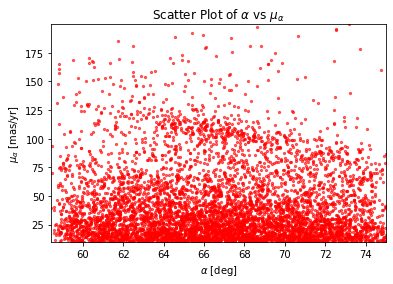

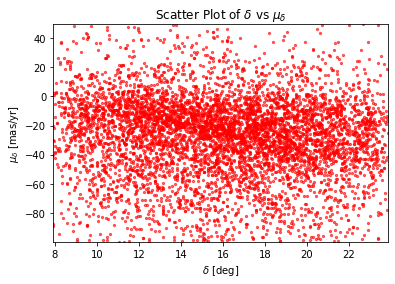

In [6]:
#memory_hyades.clear(warn=False)
hyades = gaia_query_hyades(8, 66.75, 15.87, 5, 45, 10, 200, -100, 50)

plt.scatter(hyades['ra'], hyades['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(hyades['ra']), np.max(hyades['ra']))
plt.ylim(np.min(hyades['pmra']), np.max(hyades['pmra']))
plt.show()

plt.scatter(hyades['dec'], hyades['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(hyades['dec']), np.max(hyades['dec']))
plt.ylim(np.min(hyades['pmdec']), np.max(hyades['pmdec']))
plt.show()

After seeing these trends we noted previously, we seek to perform another query that selects data that falls within these parameters. We set tighter constraints on the radius of search, parallax, and proper motion in both right ascension and declination. We can see that the trends we noted previously are actual trends and there does appear to be a cluster.

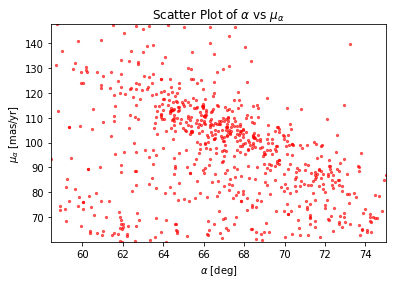

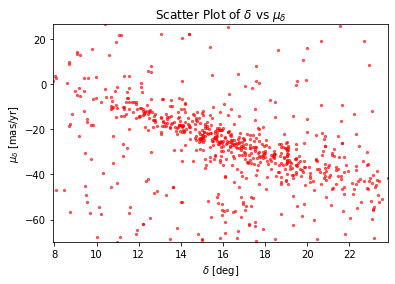

In [7]:
hyades2 = gaia_query_hyades(8, 66.75, 15.87, 8, 45, 60, 150, -70, 30)

plt.scatter(hyades2['ra'], hyades2['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(hyades2['ra']), np.max(hyades2['ra']))
plt.ylim(np.min(hyades2['pmra']), np.max(hyades2['pmra']))
plt.show()

plt.scatter(hyades2['dec'], hyades2['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(hyades2['dec']), np.max(hyades2['dec']))
plt.ylim(np.min(hyades2['pmdec']), np.max(hyades2['pmdec']))
plt.show()

This gives us a CMD as seen below. We see that there is a solid main sequence line that stands out from the excess noise stars that we can see in the lower right quadrant of the graph or in the ranges $[0, 4] \times [12.5, 20]$. We also note that there are some white dwarfs as can be seen in the graphs of [Babusiaux et al. 2018](https://arxiv.org/pdf/1804.09378.pdf)

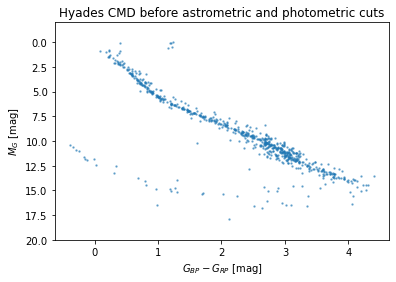

In [8]:
plt.scatter(hyades2['bp_rp'], hyades2['phot_g_mean_mag'] + 5 + 5*np.log10(hyades2['parallax']/1000), alpha=0.5, s=2)
plt.ylim(20, -2)
plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.title('Hyades CMD before astrometric and photometric cuts')
plt.show()

Now, we query Gaia again--this time using photometric cuts to get a data set that we can apply our cluster filter algorithm to. After applying the filtering algorithm we see a clea main sequence that corresponds to Hyades. We are missing a few points that can be seen in the Babusiaux graph, specifically some of the stars above the clear main sequence line. These stars above the main sequence line would appear to correspond to binary stars or higher order systems. We can see, however, that astrometric and photometric cuts provide us with a reasonable CMD for Hyades as the main sequence is clear and distinguished from any noise or binary systems.

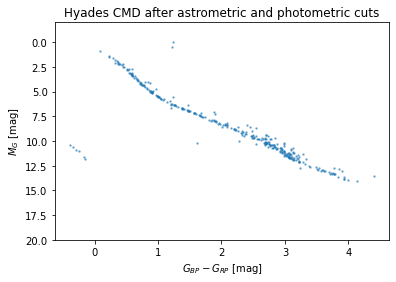

In [9]:
params = {
    'ra': 66.75,
    'dec': 15.87,
    'radius': 8,
    'pmraLB': 60,
    'pmraUB': 150,
    'pmdecLB': -80,
    'pmdecUB': 30,
    'parLB': 10,
    'parUB': 45,
    'aen': 1,
    'phot_g_mean_flux_over_error': 50,
    'phot_bp_mean_flux_over_error': 20,
    'phot_rp_mean_flux_over_error': 20
}

hyades = gaia_q_phot_filt_hyades(params)
hyades_CMD = CMD_data(hyades, 0)

plt.scatter(hyades_CMD['bp_rp'], hyades_CMD['mag'], alpha=0.5, s=2)
plt.ylim(20, -2)
plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.title('Hyades CMD after astrometric and photometric cuts')
plt.show()

We apply the same process to the M67 cluster. The literature value for the position in right ascension and declination is $(132.83, 11.82)$. The literature value for the approximate distance of the center of the cluster is 800 to 900 parsecs away. This gives us a rough parallax of $\varpi = 1.17 \text{ mas}$. We query a large positional range of 2 degrees and a right ascension proper motion range of $[-200 \text{ mas}/\text{yr}, 200 \text{ mas}/\text{yr}]$ and a declination proper motion range of $[-100, 100]$. We cannot see any immediate trends like we did with Hyades. However, there might be a trend at $\mu_{\alpha} \approx -10 \text{ mas}/\text{yr}$ ranging from $\alpha = 131.5 \text{ mas}/\text{yr}$ to $\alpha = 134.5 \text{ deg}$ and $\mu_{\alpha} = -9 \text{ mas}/\text{yr}$ to $\mu_{\alpha} = -14 \text{ mas}/\text{yr}$. So, we need to zoom in further.

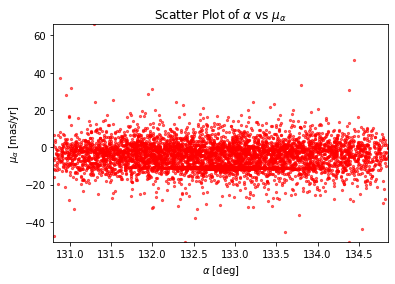

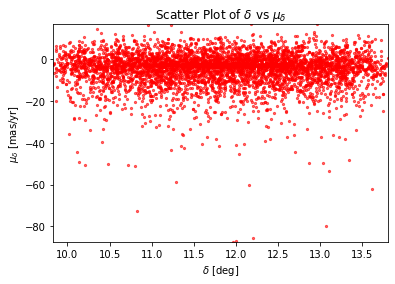

In [10]:
m67 = gaia_query_m67(2, 132.825, 11.816667, 1.05, 1.3, -200, 200, -100, 100)

plt.scatter(m67['ra'], m67['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(m67['ra']), np.max(m67['ra']))
plt.ylim(np.min(m67['pmra']), np.max(m67['pmra']))
plt.show()

plt.scatter(m67['dec'], m67['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(m67['dec']), np.max(m67['dec']))
plt.ylim(np.min(m67['pmdec']), np.max(m67['pmdec']))
plt.show()

We can see points clustered about $\mu_{\alpha} = -11 \text{ mas}/\text{yr}$ ranging from $\alpha = 131.5 \text{ deg}$ to $\alpha = 134 \text{ deg}$ and $\mu_{\alpha} = -12 \text{ mas}/\text{yr}$ to $\mu_{\alpha} = -10 \text{ mas}/\text{yr}$ and about $\mu_{\delta} = -3 \text{ mas}/\text{yr}$ ranging from $\delta = 10.5 \text{ deg}$ to $\delta = 13 \text{ deg}$ and $\mu_{\delta} = -5\text{ mas}/\text{yr}$ to $\mu_{\delta} = 0\text{ mas}/\text{yr}$. Just plotting these points alone on a CMD gives us the plot below. We can see that it has characteristics of the one seen in Babusiaux, yet there is a lot of excess noise and there is not a clearly defined main sequence line.

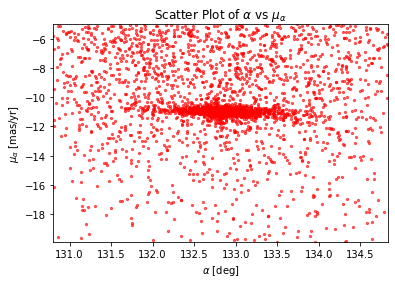

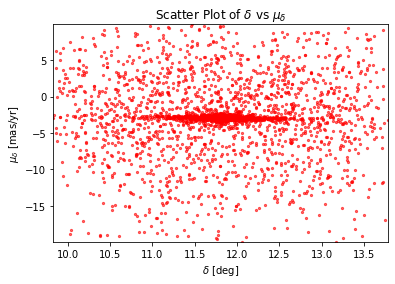

In [11]:
m67 = gaia_query_m67(2, 132.825, 11.816667, 1.05, 1.3, -20, -5, -20, 10)

plt.scatter(m67['ra'], m67['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(m67['ra']), np.max(m67['ra']))
plt.ylim(np.min(m67['pmra']), np.max(m67['pmra']))
plt.show()
plt.scatter(m67['dec'], m67['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(m67['dec']), np.max(m67['dec']))
plt.ylim(np.min(m67['pmdec']), np.max(m67['pmdec']))
plt.show()

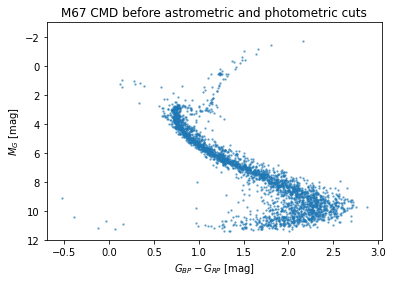

In [12]:
plt.scatter(m67['bp_rp'], m67['phot_g_mean_mag'] + 5 + 5*np.log10(m67['parallax']/1000), alpha=0.5, s=2)
plt.ylim(12, -3)
plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.title('M67 CMD before astrometric and photometric cuts')
plt.show()

We want to apply further astrometric cuts but now photometric cuts as well so we query Gaia again searching for stars that fall within stricter astrometric parameters. Additionally, we ease up on the photometric cuts because the more stringent constraints can cut out too many stars since it is harder to measure the flux values for these farther clusters and stars such as M67 when compared to Hyades which is roughly $1/17^{\text{th}}$ the distance. After applying these cuts we get a CMD that looks very much like the one seen in Babusiaux. There is a clearly defined main sequence line with many stars above the main sequence line that appear to be binary stars or stars in higher order systems.

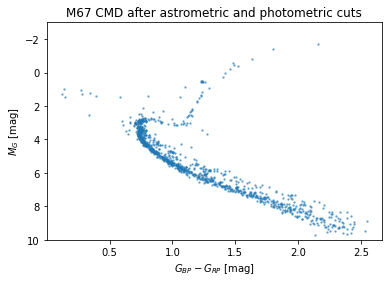

In [13]:
params = {
    'ra': 132.825,
    'dec': 11.816667,
    'radius': 1.5,
    'pmraLB': -13,
    'pmraUB': -9,
    'pmdecLB': -5,
    'pmdecUB': 0,
    'parLB': 1.05,
    'parUB': 1.3,
    'aen': 2,
    'phot_g_mean_flux_over_error': 45,
    'phot_bp_mean_flux_over_error': 15,
    'phot_rp_mean_flux_over_error': 15
}

m67 = gaia_q_phot_filt_m67(params)
m67_CMD = CMD_data(m67, 0)

plt.scatter(m67_CMD['bp_rp'], m67_CMD['mag'], alpha=0.5, s=2)
plt.ylim(10, -3)
plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.title('M67 CMD after astrometric and photometric cuts')
plt.show()

The literature value for the center of the NGC 6397 cluster in (right ascension, declination) is $(265.18 \text{ deg}, -53.674 \text{ deg})$ and the distance from the earth to the center of the cluster is approximately 2400 parsecs giving us a parallax of $\varpi = 0.4167 \text{ mas}$. We search in a circle of radius size 1 about the center of the cluster and a parallax range of $0.3 \text{ mas}, 0.5 \text{ mas}$, a range of $[-100 \text{ mas}/\text{yr}, 100 \text{ mas}/\text{yr}]$ for $\mu_{\alpha}$ and a range of $[-100 \text{ mas}/\text{yr}, 100 \text{ mas}/\text{yr}]$ for $\mu_{\delta}$. We cannot see a trend in the right ascension proper motion values but there does appear to be a point about which the cluster condenses around in the phase space diagram for declination centered at approximately $\mu_{\delta} = -18 \text{ mas}/\text{yr}$ with a range of $[-25, -15]$.

INFO: Query finished. [astroquery.utils.tap.core]


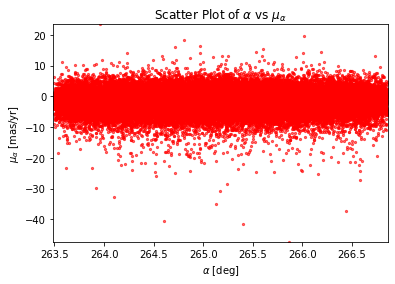

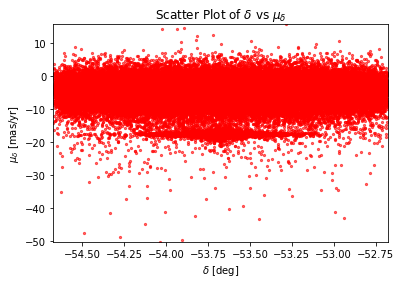

In [14]:
ngc6397 = gaia_query_ngc6397(1, 265.1750, -53.6744, 0.3, 0.5, -100, 100, -100, 100)

plt.scatter(ngc6397['ra'], ngc6397['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(ngc6397['ra']), np.max(ngc6397['ra']))
plt.ylim(np.min(ngc6397['pmra']), np.max(ngc6397['pmra']))
plt.show()

plt.scatter(ngc6397['dec'], ngc6397['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(ngc6397['dec']), np.max(ngc6397['dec']))
plt.ylim(np.min(ngc6397['pmdec']), np.max(ngc6397['pmdec']))
plt.show()

We can see that there is a diamond shaped cluster in phase space in both right ascension and declination ranging from $[0 \text{ mas}/\text{yr}, 5 \text{ mas}/\text{yr}]$ in right ascension proper motion and $[-20 \text{ mas}/\text{yr}, -16 \text{ mas}/\text{yr}]$ in declination proper motion over a $0.75 \text{ deg}$ radius in both right ascension and declination.

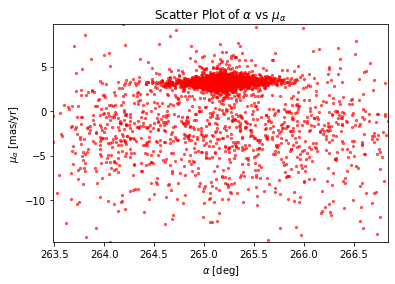

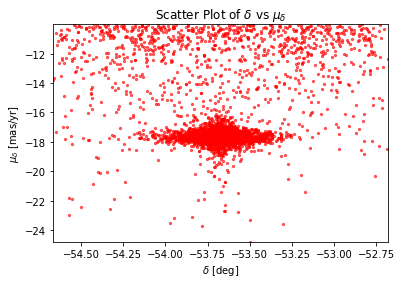

In [15]:
ngc6397 = gaia_query_ngc6397(1, 265.1750, -53.6744, 0.4, 0.45, -15, 10, -25, -10)

plt.scatter(ngc6397['ra'], ngc6397['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(ngc6397['ra']), np.max(ngc6397['ra']))
plt.ylim(np.min(ngc6397['pmra']), np.max(ngc6397['pmra']))
plt.show()

plt.scatter(ngc6397['dec'], ngc6397['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(ngc6397['dec']), np.max(ngc6397['dec']))
plt.ylim(np.min(ngc6397['pmdec']), np.max(ngc6397['pmdec']))
plt.show()

Again, we see a clearly delineated agglomeration of points.

1909


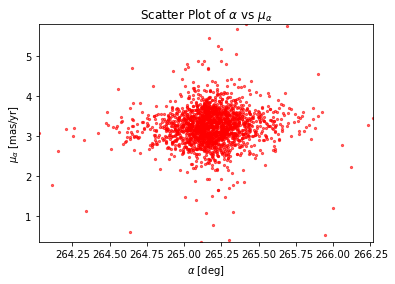

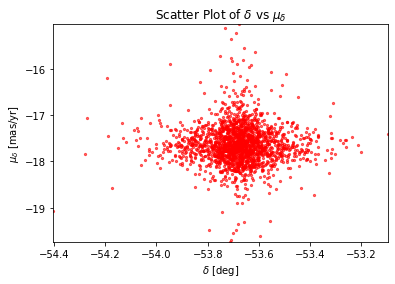

In [16]:
ngc6397 = gaia_query_ngc6397(0.75, 265.1750, -53.6744, 0.4, 0.43, 0, 6, -20, -15)

print(len(ngc6397['ra']))

plt.scatter(ngc6397['ra'], ngc6397['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(ngc6397['ra']), np.max(ngc6397['ra']))
plt.ylim(np.min(ngc6397['pmra']), np.max(ngc6397['pmra']))
plt.show()

plt.scatter(ngc6397['dec'], ngc6397['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(ngc6397['dec']), np.max(ngc6397['dec']))
plt.ylim(np.min(ngc6397['pmdec']), np.max(ngc6397['pmdec']))
plt.show()

We see a defined main sequence line with some blue stragglers left and above the clearly visible and densely populated turnoff point from the main sequence. However, there is quite a spread of stars due to excess noise and we do not get a one-dimensional graph that we would desire. Since this cluster is much farther than the other two, we must apply less stringent photometric cuts to receive a graph that accurately captures the CMD of the cluster.

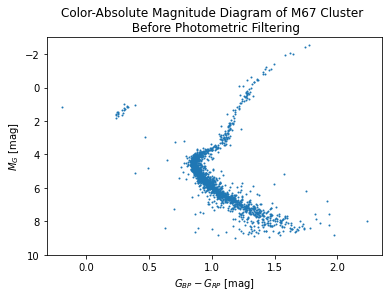

In [17]:
plt.scatter(ngc6397['bp_rp'], ngc6397['phot_g_mean_mag'] + 5 + 5*np.log10(ngc6397['parallax']/1000), s=1)
plt.ylim(10, -3)
plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.title('Color-Absolute Magnitude Diagram of M67 Cluster \n Before Photometric Filtering')
plt.show()

INFO: Query finished. [astroquery.utils.tap.core]


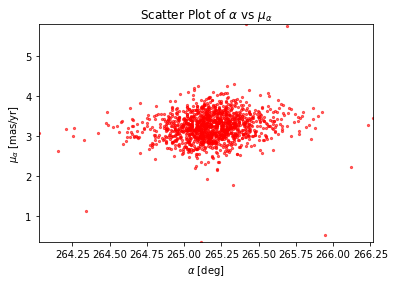

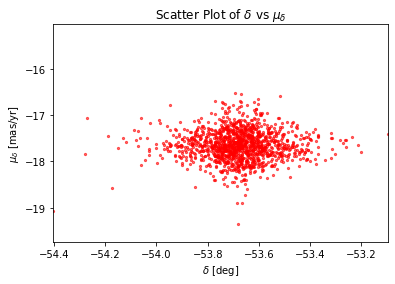

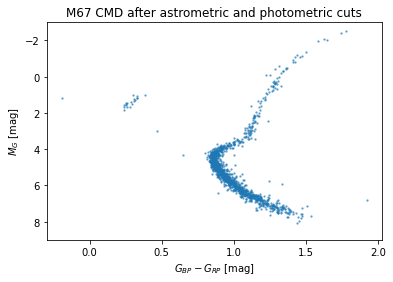

In [18]:
params = {
    'ra': 265.1750,
    'dec': -53.6744,
    'radius': 0.75,
    'pmraLB': 0,
    'pmraUB': 6,
    'pmdecLB': -20,
    'pmdecUB': -15,
    'parLB': 0.4,
    'parUB': 0.43,
    'aen': 1.5,
    'phot_g_mean_flux_over_error': 50,
    'phot_bp_mean_flux_over_error': 20,
    'phot_rp_mean_flux_over_error': 20
}

ngc6397_CMD = gaia_q_phot_filt_ngc6397(params)

plt.scatter(ngc6397_CMD['ra'], ngc6397_CMD['pmra'], color='r', alpha=0.6, s=5)
plt.xlabel('$\\alpha$ [deg]')
plt.ylabel('$\mu_{\\alpha}$ [mas/yr]')
plt.title('Scatter Plot of $\\alpha$ vs $\mu_{\\alpha}$')
plt.xlim(np.min(ngc6397_CMD['ra']), np.max(ngc6397_CMD['ra']))
plt.ylim(np.min(ngc6397_CMD['pmra']), np.max(ngc6397_CMD['pmra']))
plt.show()

plt.scatter(ngc6397_CMD['dec'], ngc6397_CMD['pmdec'], color='r', alpha=0.6, s=5)
plt.xlabel('$\delta$ [deg]')
plt.ylabel('$\mu_{\delta}$ [mas/yr]')
plt.title('Scatter Plot of $\delta$ vs $\mu_{\delta}$')
plt.xlim(np.min(ngc6397['dec']), np.max(ngc6397['dec']))
plt.ylim(np.min(ngc6397['pmdec']), np.max(ngc6397['pmdec']))
plt.show()

plt.scatter(ngc6397_CMD['bp_rp'], ngc6397_CMD['phot_g_mean_mag'] + 5 \
            + 5*np.log10(ngc6397_CMD['parallax']/1000), alpha=0.5, s=2)
plt.ylim(9, -3)
plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.title('M67 CMD after astrometric and photometric cuts')
plt.show()

We graph a collection of isochrones corresponding to a fixed metallicity with variable age. We do this for various metallicities. This allows us to compare and contrast which metallicities and ages fit the data the best. Below, we can see that the age that best fits Hyades is $\text{log}(\text{age}) = 8.79$ since this correctly captures the turnoff point of the main sequence and while the two stars that have moved off of the main sequence are closer to the $\text{log}(\text{age}) = 9.79$ isochrone, that isochrone does not capture the turn off point from the main sequence at all. But, since this isochrone does not fit the data exactly and the data seems to be in between the $8.79$ and $9.79$ age isochrones, we pick an age that is in between these two yet much closer to $8.79$. Thus, the age we pick is approximately $\text{log}(\text{age}) = 9.0$. It is hard to determine from these metallicity values the true metallicity value, but it looks like it could be anywhere in between $0.01$ and $0.03$ and so we pick a mean value of $0.02$.

For Hyades, we can see that there is a clearly defined main sequence line where most of the stars reside. Additionally, there are a few stars that have moved off of the main sequence and appear to be blue loop stars. Finally, there are a few white dwarves at the tail end of the isochrones. Additionally, there appears to be numerous binaries as can be seen by the manifestation of numerous stars slightly above the main sequence line.

Reading in: hyades_mist/MIST_iso_601db58881e51.iso.cmd


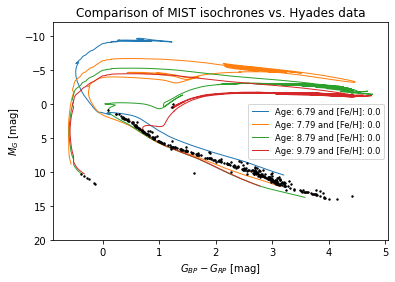

Reading in: hyades_mist/MIST_iso_601db59d6ed13.iso.cmd


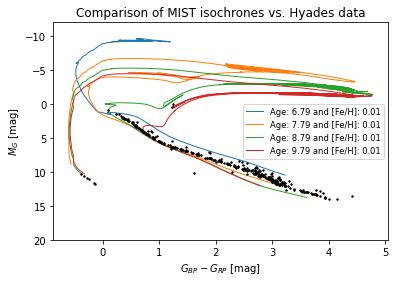

Reading in: hyades_mist/MIST_iso_601db5b01187a.iso.cmd


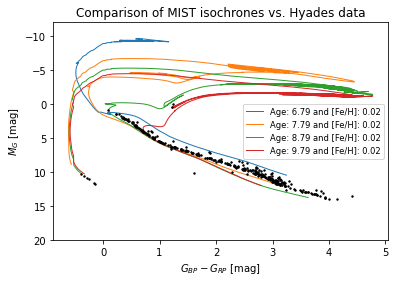

Reading in: hyades_mist/MIST_iso_601db5c01c7b6.iso.cmd


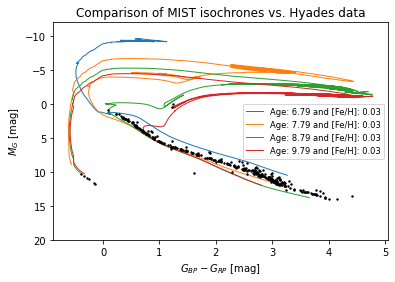

In [19]:
hyades_mist = [
    'MIST_iso_601db58881e51.iso.cmd',
    'MIST_iso_601db59d6ed13.iso.cmd',
    'MIST_iso_601db5b01187a.iso.cmd',
    'MIST_iso_601db5c01c7b6.iso.cmd'
]

for iso in hyades_mist:
    
    hyades_isocmd = read_mist_models.ISOCMD(f'hyades_mist/{iso}')
    
    ages = hyades_isocmd.ages
    fe_h = hyades_isocmd.abun['[Fe/H]']

    for age in ages:

        age_ind = hyades_isocmd.age_index(age)
        plt.plot(hyades_isocmd.isocmds[age_ind]['Gaia_BP_EDR3'] - hyades_isocmd.isocmds[age_ind]['Gaia_RP_EDR3'], \
                 hyades_isocmd.isocmds[age_ind]['Gaia_G_EDR3'], linewidth=1, label=f'Age: {age} and [Fe/H]: {fe_h}')
        plt.legend(fontsize='small')
        plt.ylim(20, -12)


    plt.scatter(hyades_CMD['bp_rp'], hyades_CMD['mag'], color='k', s=2, zorder=54)
    plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
    plt.ylabel('$M_G$ [mag]')
    plt.title('Comparison of MIST isochrones vs. Hyades data')
    plt.show()

For the M67 cluster, we can see immediately that the $\text{log}(\text{age}) = 9.5$ isochrone fits the main sequence and the turn off point very well. Hence, we pick this to be the age of the cluster. As for the metallicity, we can see that as the metallicity increases that the curve moves away from the main sequence turnoff point, so we conclude that it isn't 0.14 or 0.20. We can see that it is somewhere inbetween 0.0 and 0.04, but there are quite a few what appear to be blue stragglers and binary or higher order systems that make it hard to determine a hardline main sequence line even though the turn off point is clearly delineated. So, we choose an intermediate value of 0.02.

In the M67 cluster, we can see a clearly defined main sequence that is densely populated with many stars, many of which reside above the main sequence line. This indicates to us that there are numerous systems in binaries or higher order systems. Moreover, the turn off point from the main sequence is clearly defined and we can see many stars transitioning to the red giant branch or they are already on the red giant branch. There also appear to be some blue stragglers that are off to the left of the turn off point.

Reading in: m67_mist/MIST_iso_601db99126598.iso.cmd


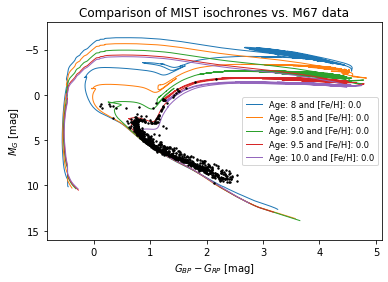

Reading in: m67_mist/MIST_iso_601dbb57c84ce.iso.cmd


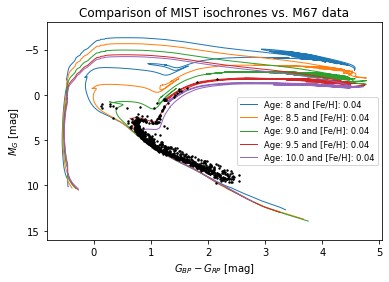

Reading in: m67_mist/MIST_iso_601dbc0fc71b3.iso.cmd


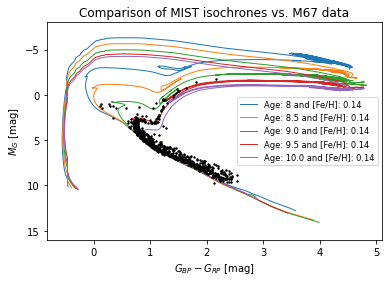

Reading in: m67_mist/MIST_iso_601dbad848437.iso.cmd


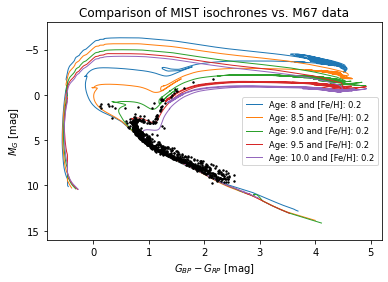

In [20]:
m67_mist = [
    'MIST_iso_601db99126598.iso.cmd',
    'MIST_iso_601dbb57c84ce.iso.cmd',
    'MIST_iso_601dbc0fc71b3.iso.cmd',
    'MIST_iso_601dbad848437.iso.cmd'
]

for iso in m67_mist:
    
    m67_isocmd = read_mist_models.ISOCMD(f'm67_mist/{iso}')
    
    ages = [8, 8.5, 9.0, 9.5, 10.0]
    fe_h = m67_isocmd.abun['[Fe/H]']

    for age in ages:

        age_ind = m67_isocmd.age_index(age)
        plt.plot(m67_isocmd.isocmds[age_ind]['Gaia_BP_EDR3'] - m67_isocmd.isocmds[age_ind]['Gaia_RP_EDR3'], \
                 m67_isocmd.isocmds[age_ind]['Gaia_G_EDR3'], linewidth=1, label=f'Age: {age} and [Fe/H]: {fe_h}')
        plt.legend(fontsize='small')


    plt.scatter(m67_CMD['bp_rp'], m67_CMD['mag'], color='k', s=2, zorder=54)
    plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
    plt.ylabel('$M_G$ [mag]')
    plt.title('Comparison of MIST isochrones vs. M67 data')
    plt.ylim(16, -8)
    plt.show()

We used the same process as for the two previous clusters. For NGC 6397, it is harder to determine what the age is since none of the isochrones seem to match up neatly with the main sequence or the turn off point. However, we can see that the data lies in between $\text{log}(\text{age}) = 9.8$ and $\text{log}(\text{age}) = 10.3$. Thus, we estimate the age of the cluster to be approximately $\text{log}(\text{age}) = 10.05$. Again, trying to determine the metallicity of the cluster is not simple as all of the metallicities appear to be close to the cluster's actual metallicity given the determined estimated age. We see though as the value increases towards $-1.90$ our isochrones seem to match up less with the cluster, and so we believe that the value must be closer towards the lower end of values we sampled. Hence, we pick the value of $-1.71$ for the cluster's metallicity.

For NGC 6397 we again see a clearly defined main sequence line that is densely populated with a turn off point that is also clear and densely populated. This cluster appears to be composed of lower mass stars around $1 M_{\odot}$. We can see that many of the stars have entered onto the red giant branch. There appear to be a clump of stars that appear to be blue stragglers as well. Lastly, we see one white dwarf star. There appear to be numerous stars that are in binary or higher order systems as we can see the spread of stars from the main sequence.

Reading in: ngc6397_mist/MIST_iso_601db5f66cdb2.iso.cmd


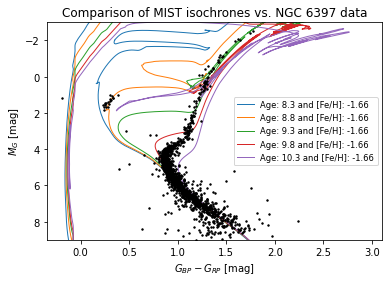

Reading in: ngc6397_mist/MIST_iso_601db671dc746.iso.cmd


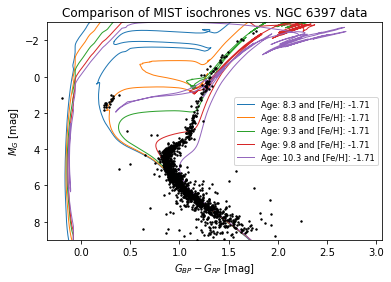

Reading in: ngc6397_mist/MIST_iso_601db6c5501ba.iso.cmd


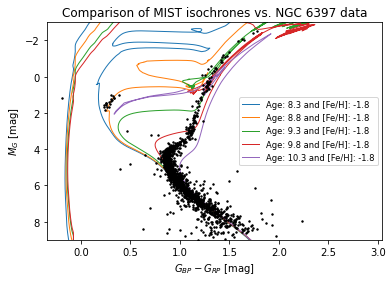

Reading in: ngc6397_mist/MIST_iso_601db6e856804.iso.cmd


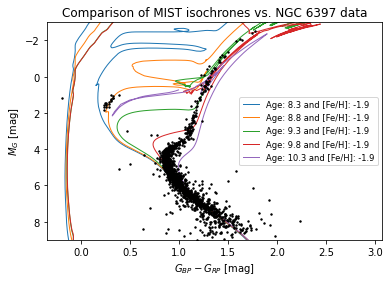

In [21]:
ngc6397_mist = [
    'MIST_iso_601db5f66cdb2.iso.cmd',
    'MIST_iso_601db671dc746.iso.cmd',
    'MIST_iso_601db6c5501ba.iso.cmd',
    'MIST_iso_601db6e856804.iso.cmd'
]

for iso in ngc6397_mist:
    
    ngc6397_isocmd = read_mist_models.ISOCMD(f'ngc6397_mist/{iso}')
    
    ages = ngc6397_isocmd.ages
    fe_h = ngc6397_isocmd.abun['[Fe/H]']

    for age in ages:

        age_ind = ngc6397_isocmd.age_index(age)
        plt.plot(ngc6397_isocmd.isocmds[age_ind]['Gaia_BP_EDR3'] - ngc6397_isocmd.isocmds[age_ind]['Gaia_RP_EDR3'], \
                 ngc6397_isocmd.isocmds[age_ind]['Gaia_G_EDR3'], linewidth=1, label=f'Age: {age} and [Fe/H]: {fe_h}')
        plt.legend(fontsize='small')
        plt.ylim(9, -3)


    plt.scatter(ngc6397['bp_rp'], ngc6397['phot_g_mean_mag'] + 5 + 5*np.log10(ngc6397['parallax']/1000)\
                , color='k', s=2, zorder=54)
    plt.xlabel('$G_{BP} - G_{RP}$ [mag]')
    plt.ylabel('$M_G$ [mag]')
    plt.title('Comparison of MIST isochrones vs. NGC 6397 data')
    plt.show()

Now, we use PARSEC models to compare with our data instead of MIST models.

For Hyades, we do not see a major discrepancy between the MIST and PARSEC models. We obtain the same result as we did with the MIST models: the best fit age is 8.79 and the best fit metallicity is closer to 0 than it is towards 0.1 or -0.1. Again, we did find that there are binaries because there appeared to be a strong main sequence line with some stars above the line. Moreover, we can see the clear stages of stellar evolution. Most of the Hyades stars are on the main sequence while a few have moved off and are blue loop stars while the remaining stars seem to be white dwarfs which the PARSEC models are unable to capture unlike the MIST models.

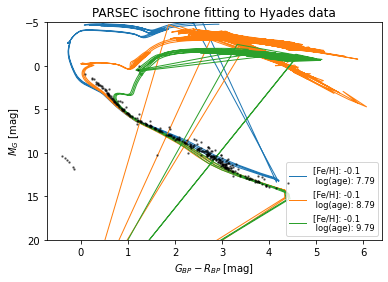

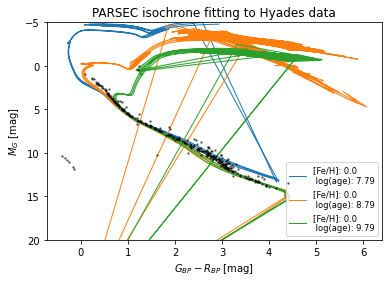

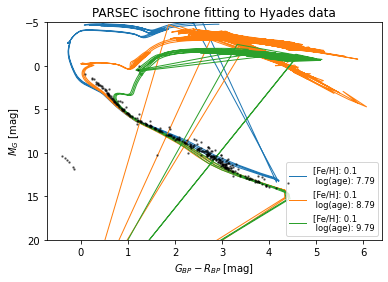

In [43]:
hyades_parsec = parsec_data('hyades', [7.79, 8.79, 9.79], [-1, 0, 1])

# metallicity and age arrays to be used for looping to graph the data #

metal_arr = [-0.1, 0.0, 0.1]
age_arr = [7.79, 8.79, 9.79]

for i in range(len(metal_arr)):
    
    for j in range(len(age_arr)):
    
        plt.plot(hyades_parsec[i][j]['bp_rp'], hyades_parsec[i][j]['mag'], linewidth=1, \
                 label=f'[Fe/H]: {metal_arr[i]} \n log(age): {age_arr[j]}')
        plt.ylim(20, -5)
    
    plt.scatter(hyades_CMD['bp_rp'], hyades_CMD['mag'], alpha=0.5, s=2, zorder=54, color='k')
    plt.xlabel('$G_{BP} - R_{BP}$ [mag]')
    plt.ylabel('$M_G$ [mag]')
    plt.title(f'PARSEC isochrone fitting to Hyades data')
    plt.legend(fontsize='small', loc='lower right')
    plt.show()

For M67, we find that the best age is $\log{(\text{age})} = 9.5$ and we can see that if the age were even higher, say, $\log{(\text{age})} = 9.6$ then the fit would be better. As for the metallicity, it is hard to find a metallicity that fits the best, but it does appear that as the metallicity becomes more positive the better the fit is. So, we choose a metallicity of 0.05 as the best fit. Like the MIST models, we see a clearly defined turn off point and main sequence line with numerous stars that are in binary or higher order systems. Moreover, we clearly see many stars moving off to the red giant branch that have turned off of the main sequence. Lastly, we see that the blue stragglers are to the left of the turn off point and there is no curve that captures their position. The PARSEC models do not appear to differ from the MIST models.

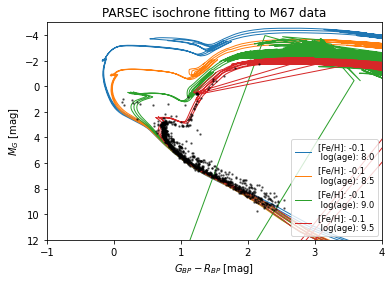

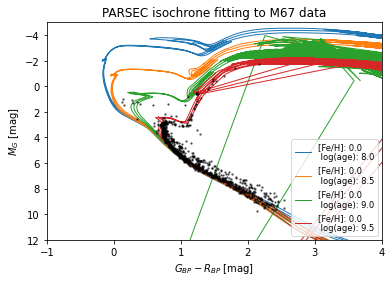

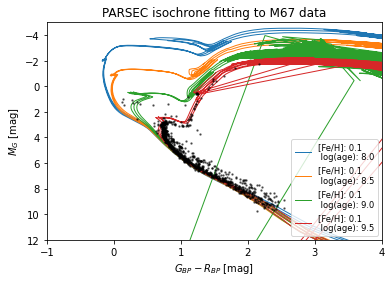

In [44]:
m67_parsec = parsec_data('m67', [8.0, 8.50, 9.0, 9.5], [-1, 0, 1])

# metallicity and age arrays to be used for looping to graph the data #

metal_arr = [-0.1, 0.0, 0.1]
age_arr = [8.0, 8.50, 9.0, 9.50]

for i in range(len(metal_arr)):
    
    for j in range(len(age_arr)):
    
        plt.plot(m67_parsec[i][j]['bp_rp'], m67_parsec[i][j]['mag'], linewidth=1, \
                 label=f'[Fe/H]: {metal_arr[i]} \n log(age): {age_arr[j]}')
        plt.ylim(12, -5)
        plt.xlim(-1, 4)
    
    plt.scatter(m67_CMD['bp_rp'], m67_CMD['mag'], alpha=0.5, s=2, zorder=54, color='k')
    plt.xlabel('$G_{BP} - R_{BP}$ [mag]')
    plt.ylabel('$M_G$ [mag]')
    plt.title('PARSEC isochrone fitting to M67 data')
    plt.legend(fontsize='small', loc='lower right')
    plt.show()

For NGC 6397, we find that the best age is between $\log{(\text{age})}=9.88$ and $\log{(\text{age})}=10.13$, but the age does appear to be closer to $9.88$, so we choose that to be the age. As for the metallicity, it is hard to determine what it is, but it appears that 1.9 is the best value. There is a clear turn off point and main sequence, and the stars that have turned off of the main sequence clearly move along the red giant branch excepting the few what appear to be blue stragglers to the left of the turn off point. Again, like with M67, there are many stars that are in higher order systems since the main sequence line appears to be more than just a line but a dense blob. We could find no major discrepancies between the MIST and PARSEC models. 

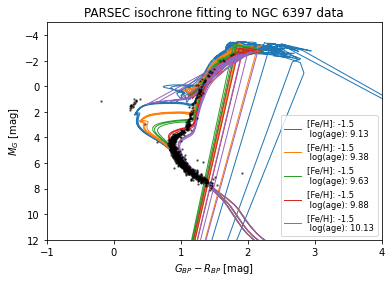

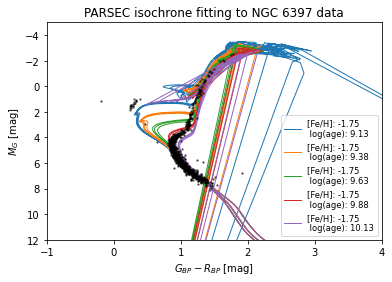

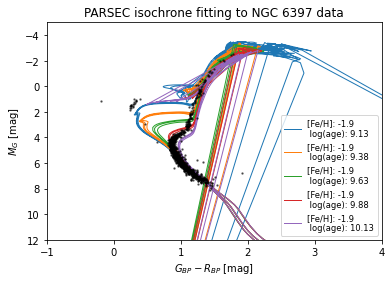

In [45]:
ngc6397_parsec = parsec_data('ngc6397', [9.13, 9.38, 9.63, 9.88, 10.13], [-15, -175, -19])

# metallicity and age arrays to be used for looping to graph the data #

metal_arr = [-1.50, -1.75, -1.90]
age_arr = [9.13, 9.38, 9.63, 9.88, 10.13]

for i in range(len(metal_arr)):
    
    for j in range(len(age_arr)):
    
        plt.plot(ngc6397_parsec[i][j]['bp_rp'], ngc6397_parsec[i][j]['mag'], linewidth=1, \
                 label=f'[Fe/H]: {metal_arr[i]} \n log(age): {age_arr[j]}')
        plt.ylim(12, -5)
        plt.xlim(-1, 4)
    
    plt.scatter(ngc6397_CMD['bp_rp'], ngc6397_CMD['phot_g_mean_mag'] + 5 \
            + 5*np.log10(ngc6397_CMD['parallax']/1000), alpha=0.5, s=2, zorder=54, color='k')
    plt.xlabel('$G_{BP} - R_{BP}$ [mag]')
    plt.ylabel('$M_G$ [mag]')
    plt.title('PARSEC isochrone fitting to NGC 6397 data')
    plt.legend(fontsize='small', loc='lower right')
    plt.show()